In [1]:
%config Completer.use_jedi = False

In [34]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [3]:
datos = pd.read_csv('datos.csv')

In [4]:
datos.head()

,colonia,alcaldia,bimestre,consumo_total,idh
0,1A. AMPLIACION PRESIDENTES,ALVARO OBREGON,1,2968.52,0.836
1,1A. AMPLIACION PRESIDENTES,ALVARO OBREGON,2,3092.45,0.836
2,1A. AMPLIACION PRESIDENTES,ALVARO OBREGON,3,3114.91,0.836
3,1A. VICTORIA,ALVARO OBREGON,1,11249.78,0.836
4,1A. VICTORIA,ALVARO OBREGON,2,11768.77,0.836


In [5]:
datos.dtypes

colonia           object
alcaldia          object
bimestre           int64
consumo_total    float64
idh              float64
dtype: object

In [6]:
X = datos.drop(columns=['consumo_total', 'colonia'])

In [7]:
y = datos['consumo_total']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [9]:
nom_cols = X_train.select_dtypes(include=['object', 'int64']).columns.to_list()

In [10]:
preprocessor_nom = ColumnTransformer(transformers=[('OneHot',
                                                    OneHotEncoder(handle_unknown='ignore', sparse=False),
                                                    nom_cols)])

In [11]:
X_train_prep = preprocessor_nom.fit_transform(X_train)
X_test_prep = preprocessor_nom.fit_transform(X_test)

In [12]:
col_names_nom = preprocessor_nom.named_transformers_['OneHot'].get_feature_names(nom_cols)

In [13]:
X_train_prep_df = pd.DataFrame(data=X_train_prep, columns=col_names_nom)

X_test_prep_df = pd.DataFrame(data=X_test_prep, columns=col_names_nom)

In [36]:
X_train_prep_df.shape

(3380, 19)

In [24]:
param_grid = {'n_estimators': [100, 150, 300, 500],
              'max_features': [5, 7, 10, 15, 19],
              'max_depth'   : [None, 3, 10, 20, 50]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep_df, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
43,10,5,500,-50538.866668,6032.925643,-49047.847456,1511.290454
42,10,5,300,-50543.585216,6022.623515,-49046.604112,1513.130804
41,10,5,150,-50544.268955,6033.394509,-49051.874817,1512.515127
40,10,5,100,-50554.405864,5990.555448,-49053.857912,1511.520537


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 305, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 878, in check_X_y
    estimator=estimator)
  File

In [25]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 10, 'max_features': 5, 'n_estimators': 500} : -50538.866667915034 neg_root_mean_squared_error


In [29]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test_prep_df)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 64082.12186073406


In [32]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_prep_df,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train_prep_df.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
5,7754.064337,171.983682,alcaldia_CUAUHTEMOC
2,2679.751739,158.087240,alcaldia_BENITO JUAREZ
10,954.386496,55.466063,alcaldia_MIGUEL HIDALGO
12,292.670165,124.013599,alcaldia_TLAHUAC
15,275.917161,90.735857,alcaldia_XOCHIMILCO
8,264.516894,115.130997,alcaldia_IZTAPALAPA
7,235.451544,36.046569,alcaldia_IZTACALCO
17,172.967104,99.225397,bimestre_2
11,171.069853,48.694362,alcaldia_MILPA ALTA
13,149.689826,77.973834,alcaldia_TLALPAN


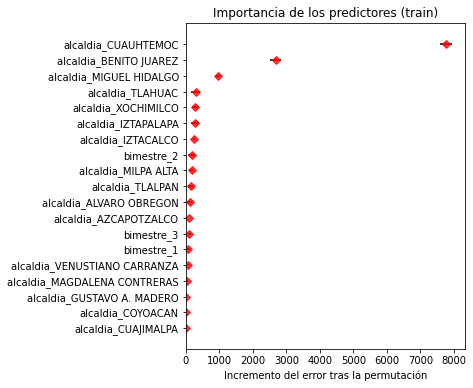

In [35]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');